Data Preprocessing 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.sparse import hstack

import warnings
warnings.filterwarnings("ignore")

# === Step 1: Read Excel with selected columns ===
cols_to_read = [
    'LOCATION', 'ROOM', 'CASE_STATUS', 'OPERATION_TYPE', 'EMERGENCY_PRIORITY',
    'SURGICAL_CODE', 'DISCIPLINE', 'SURGEON', 'ANAESTHETIST_TEAM',
    'ANESTHESIA', 'EQUIPMENT', 'ADMISSION_STATUS', 'ADMISSION_CLASS_TYPE', 'ADMISSION_TYPE',
    'ADMISSION_WARD', 'ADMISSION_BED', 'AOH', 'BLOOD', 'IMPLANT', 'DIAGNOSIS',
    'CANCER_INDICATOR', 'TRAUMA_INDICATOR', 'DIFF_SURGERY_DURATION', 'DIFF_USAGE_DURATION'
]

df = pd.read_excel("Final_Cleaned_Dataset_OPTIC_7.xlsx", usecols=cols_to_read)

In [2]:
# === Step 1a: Outlier Filtering ===
def remove_outliers_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr # can adjust multiplier
    upper = q3 + 1.5 * iqr # can adjust multiplier
    return series.between(lower, upper)

n_before = len(df)

mask_surg = remove_outliers_iqr(df['DIFF_SURGERY_DURATION'])
mask_usage = remove_outliers_iqr(df['DIFF_USAGE_DURATION'])
df = df[mask_surg & mask_usage]

n_after = len(df)
n_removed = n_before - n_after
pct_removed = (n_removed / n_before) * 100

print(f"Rows removed: {n_removed}")
print(f"Percentage removed: {pct_removed:.2f}%")

# === Step 2: Clean / preprocess columns ===
df['EMERGENCY_PRIORITY'].replace("0", np.nan, inplace=True)
df['EQUIPMENT'].replace("0", np.nan, inplace=True)
df['IMPLANT'].replace("0", np.nan, inplace=True)
df['DIAGNOSIS'].replace("not recorded", np.nan, inplace=True)

df['BLOOD'] = df['BLOOD'].apply(lambda x: False if str(x).strip().upper() == 'NIL' else True)

def categorize_text(text):
    if pd.isna(text):
        return 'Unknown'
    text = str(text).lower()
    if 'cancer' in text or 'ca' in text:
        return 'Cancer'
    if 'stone' in text:
        return 'Gallstone/Kidney'
    if 'rupture' in text or 'tear' in text:
        return 'Trauma'
    if 'pregnancy' in text:
        return 'Pregnancy'
    if 'hydrocephalus' in text:
        return 'Neuro'
    if 'subfert' in text:
        return 'Fertility'
    return 'Other'

df['IMPLANT_CAT'] = df['IMPLANT'].apply(categorize_text)
df['DIAGNOSIS_CAT'] = df['DIAGNOSIS'].apply(categorize_text)

# === Step 3: Feature Engineering ===
categorical_cols = [
    'LOCATION', 'ROOM', 'CASE_STATUS', 'OPERATION_TYPE', 'EMERGENCY_PRIORITY',
    'DISCIPLINE', 'SURGEON', 'ANAESTHETIST_TEAM',
    'ANESTHESIA', 'EQUIPMENT', 'ADMISSION_STATUS', 'ADMISSION_CLASS_TYPE',
    'ADMISSION_TYPE', 'ADMISSION_WARD', 'ADMISSION_BED', 'IMPLANT_CAT', 'DIAGNOSIS_CAT'
]

for col in categorical_cols:
    df[col] = df[col].astype(str)

bool_cols = ['AOH', 'BLOOD', 'CANCER_INDICATOR', 'TRAUMA_INDICATOR']

# Dependent variables
y = df[['DIFF_SURGERY_DURATION', 'DIFF_USAGE_DURATION']]
surgical_code_df = df[['SURGICAL_CODE']]
X_raw = df[categorical_cols + bool_cols]

# === Step 4: Define Custom Transformers ===
class SurgicalCodeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mlb = MultiLabelBinarizer(sparse_output=True)
        self.mlb.fit(X['SURGICAL_CODE'].fillna('').apply(self._split_codes))
        return self

    def transform(self, X):
        return self.mlb.transform(X['SURGICAL_CODE'].fillna('').apply(self._split_codes))

    def _split_codes(self, val):
        return [code.strip() for code in str(val).split(';') if code.strip()]

class EquipmentTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mlb = MultiLabelBinarizer(sparse_output=True)
        self.mlb.fit(X['EQUIPMENT'].fillna('').apply(self._split_equipment))
        return self

    def transform(self, X):
        return self.mlb.transform(X['EQUIPMENT'].fillna('').apply(self._split_equipment))

    def _split_equipment(self, val):
        return [item.strip().lower() for item in str(val).split(';') if item.strip()]

# === Step 5: Preprocessing Pipeline ===
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols),
        ('bool', 'passthrough', bool_cols)
    ],
    sparse_threshold=1.0
)

class FeatureCombiner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.surgical = SurgicalCodeTransformer()
        self.equipment = EquipmentTransformer()
        self.preprocessor = preprocessor

    def fit(self, X, y=None):
        X_main, X_surg, X_equipment = X
        self.surgical.fit(X_surg)
        self.equipment.fit(X_equipment)
        self.preprocessor.fit(X_main)
        return self

    def transform(self, X):
        X_main, X_surg, X_equipment = X
        X_main_proc = self.preprocessor.transform(X_main)
        X_surg_proc = self.surgical.transform(X_surg)
        X_equipment_proc = self.equipment.transform(X_equipment)
        return hstack([X_main_proc, X_surg_proc, X_equipment_proc])

Rows removed: 37040
Percentage removed: 14.89%


Performance on Differences<br>
Method: Ridge Regression

Naive Approach (no transformation)<br>
MSE (DIFF_SURGERY_DURATION): 1555.9589672336979<br>
MSE (DIFF_USAGE_DURATION): 7362.460400832329

With Yeo-Johnson Transformation<br>
MSE (DIFF_SURGERY_DURATION): 1554.0293511102093<br>
MSE (DIFF_USAGE_DURATION): 7278.200171609524

Exclude 3 * IQR Outliers, With Yeo-Johnson Transformation<br>
Rows removed: 13075<br>
Percentage removed: 5.26%<br>
MSE (DIFF_SURGERY_DURATION): 652.6590966672973<br>
MSE (DIFF_USAGE_DURATION): 793.8700146592308<br>
MAE (DIFF_SURGERY_DURATION): 17.482641526453698<br>
MAE (DIFF_USAGE_DURATION): 19.812867394396857

Exclude 1.5 * IQR Outliers, With Yeo-Johnson Transformation<br>
Rows removed: 37040<br>
Percentage removed: 14.89%<br>
MSE (DIFF_SURGERY_DURATION): 345.6797313099851<br>
MSE (DIFF_USAGE_DURATION): 442.9399566765906<br>
MAE (DIFF_SURGERY_DURATION): 13.370419824400866<br>
MAE (DIFF_USAGE_DURATION): 15.600914077659281

In [ ]:
# === Step 6: Train/Test Split ===
X_train_raw, X_test_raw, surg_train, surg_test, equip_train, equip_test, y_train, y_test = train_test_split(
    X_raw, surgical_code_df, df[['EQUIPMENT']], y, test_size=0.2, random_state=42
)

# Yeo-Johnson transform outcomes
pt_y = PowerTransformer(method='yeo-johnson')
y_train_trans = pt_y.fit_transform(y_train)
y_test_trans = pt_y.transform(y_test)

X_combiner = FeatureCombiner()
X_combiner.fit((X_train_raw, surg_train, equip_train))

X_train = X_combiner.transform((X_train_raw, surg_train, equip_train))
X_test = X_combiner.transform((X_test_raw, surg_test, equip_test))

# === Step 7: Feature Names Updated ===
feature_names = X_combiner.preprocessor.get_feature_names_out(categorical_cols + bool_cols)
surg_features = X_combiner.surgical.mlb.classes_
equipment_features = X_combiner.equipment.mlb.classes_
all_feature_names = list(feature_names) + list(surg_features) + list(equipment_features)

# === Step 8: Train Model ===
model = Ridge(alpha=1.0)
model.fit(X_train, y_train_trans)

# === Step 9: Predict & Evaluate ===
y_pred_trans = model.predict(X_test)
y_pred = pt_y.inverse_transform(y_pred_trans)  # inverse transform back

mae_surg = mean_absolute_error(y_test['DIFF_SURGERY_DURATION'], y_pred[:, 0])
mae_usage = mean_absolute_error(y_test['DIFF_USAGE_DURATION'], y_pred[:, 1])

print("MAE (DIFF_SURGERY_DURATION):", mae_surg)
print("MAE (DIFF_USAGE_DURATION):", mae_usage)

MAE (DIFF_SURGERY_DURATION): 13.370419824400866
MAE (DIFF_USAGE_DURATION): 15.600914077659281


In [ ]:
# === Step 10: Save results to txt ===
feature_names = X_combiner.preprocessor.get_feature_names_out(categorical_cols + bool_cols)
surg_features = X_combiner.surgical.mlb.classes_
all_feature_names = list(feature_names) + list(surg_features)

with open("ridge_results.txt", "w") as f:
    f.write(f"MAE (DIFF_SURGERY_DURATION): {mae_surg}\n")
    f.write(f"MAE (DIFF_USAGE_DURATION): {mae_usage}\n\n")

    for i, target in enumerate(['DIFF_SURGERY_DURATION', 'DIFF_USAGE_DURATION']):
        f.write(f"{target} = {model.intercept_[i]:.6f}")
        for coef, name in zip(model.coef_[i], all_feature_names):
            f.write(f" + ({coef:.6f} * {name})")
        f.write("\n\n")

Residuals Visualisation

In [4]:
# Generalisable Helper Function
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

def plot_residual_diagnostics(y_true, y_pred, title_prefix="Model"):
    """
    Generates residual diagnostic plots:
    - Residuals vs Fitted
    - QQ Plot of residuals
    """
    residuals = y_true - y_pred

    # --- Residuals vs Fitted ---
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"{title_prefix}: Residuals vs Fitted")
    plt.xlabel("Fitted Values (Predicted)")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

    # --- QQ Plot ---
    sm.qqplot(residuals, line='45', fit=True)
    plt.title(f"{title_prefix}: QQ Plot of Residuals")
    plt.tight_layout()
    plt.show()

def plot_residuals_vs_feature(X, residuals, feature_name, target_name, n_categories=20):
    """
    Residuals vs single feature.
    Handles numeric or categorical predictors.
    """
    feature = X[feature_name]

    plt.figure(figsize=(6, 4))
    if pd.api.types.is_numeric_dtype(feature):
        sns.scatterplot(x=feature, y=residuals, alpha=0.6)
    else:
        # Collapse rare categories for readability
        counts = feature.value_counts().nlargest(n_categories).index
        filtered = feature.where(feature.isin(counts), other="Other")
        sns.boxplot(x=filtered, y=residuals)
        plt.xticks(rotation=45)

    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residuals vs {feature_name} ({target_name})")
    plt.xlabel(feature_name)
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

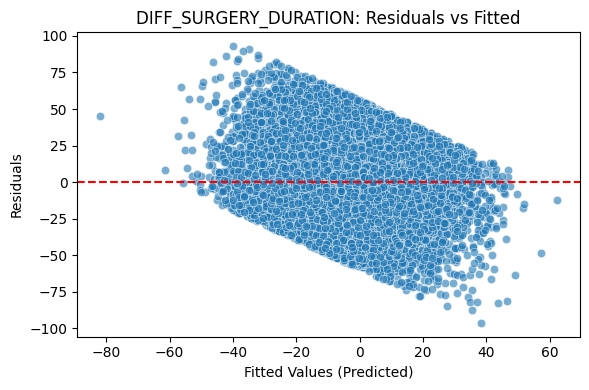

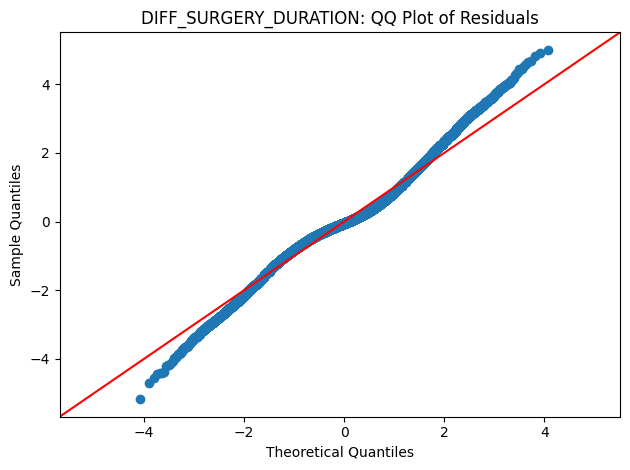

In [5]:
plot_residual_diagnostics(y_test['DIFF_SURGERY_DURATION'], y_pred[:, 0], "DIFF_SURGERY_DURATION")

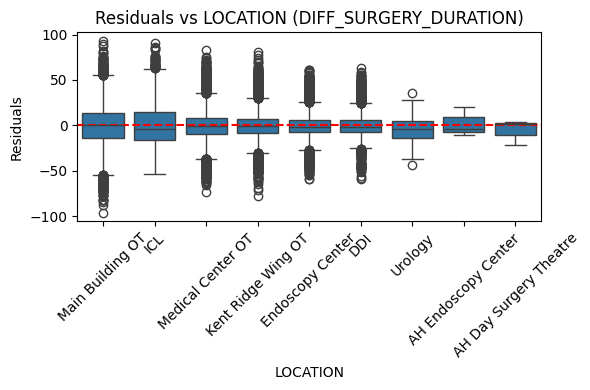

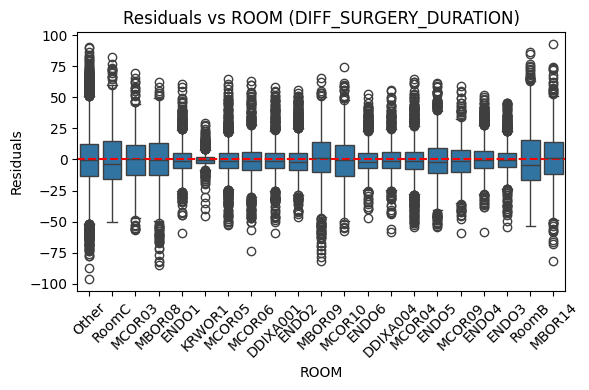

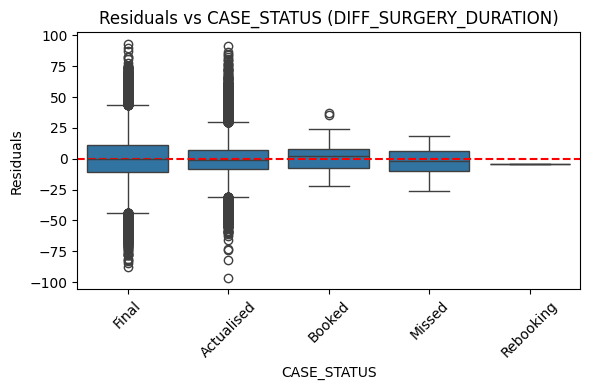

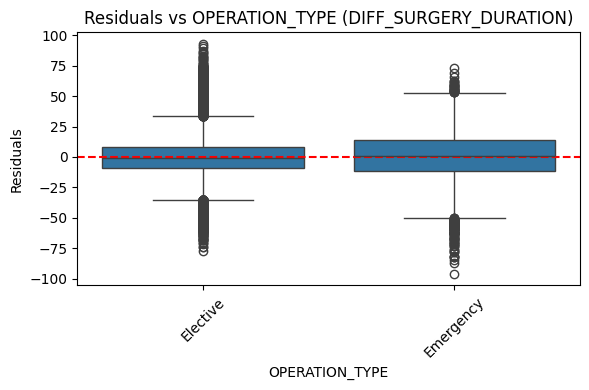

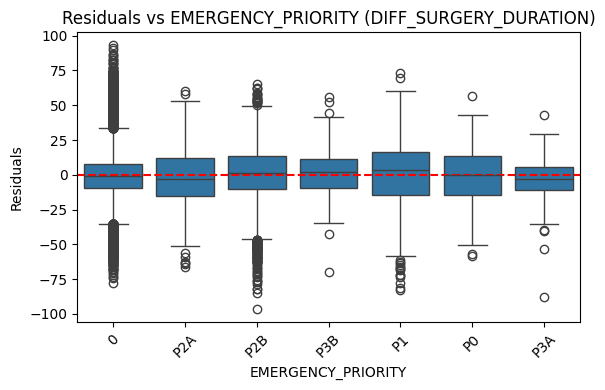

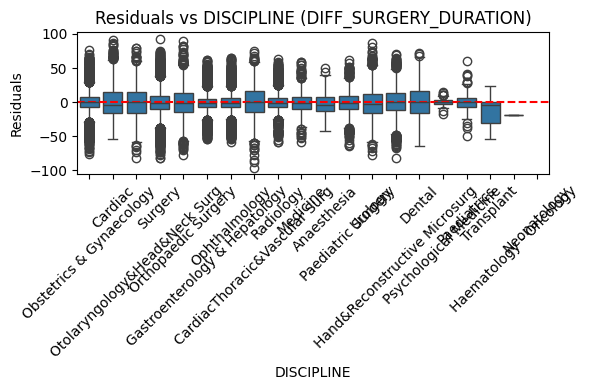

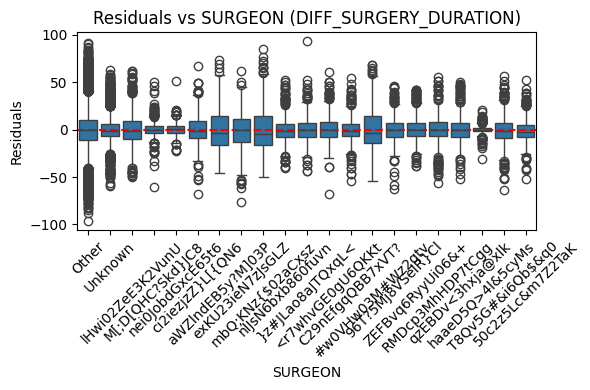

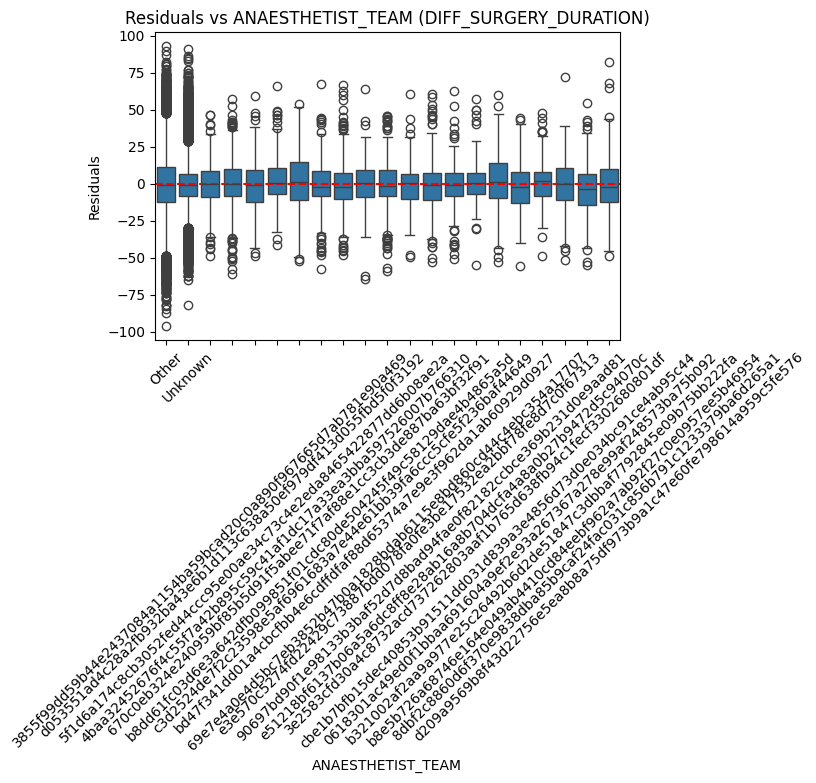

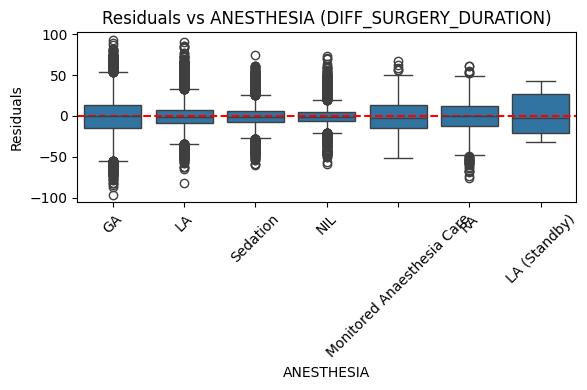

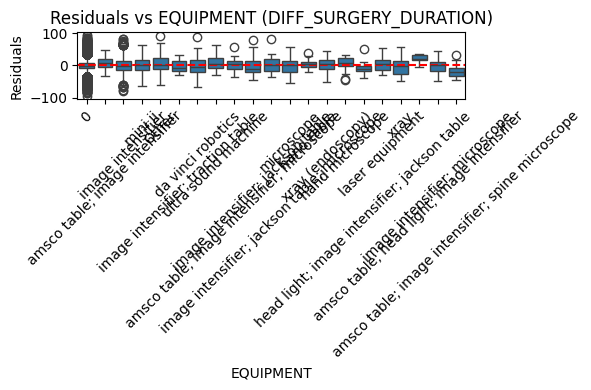

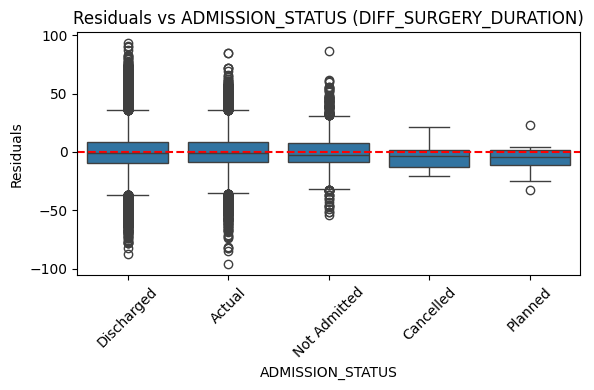

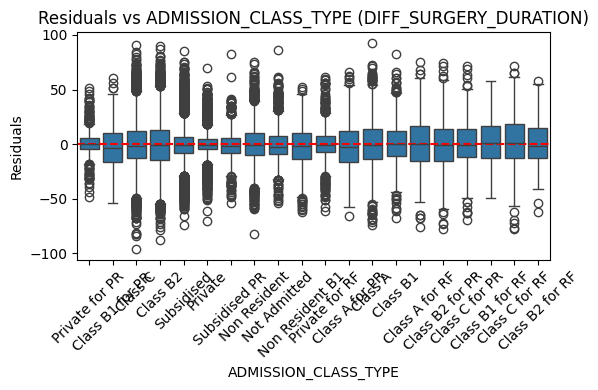

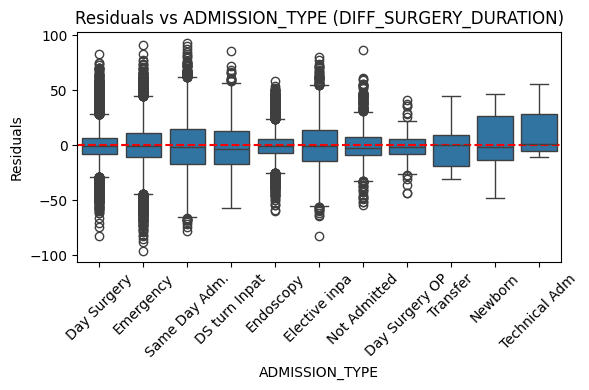

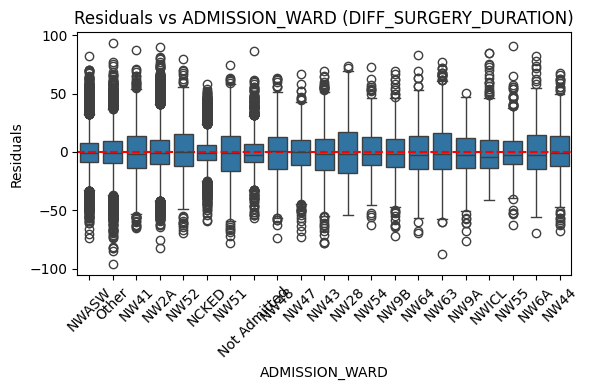

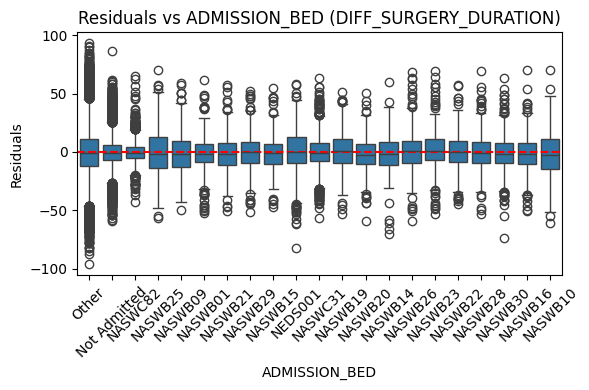

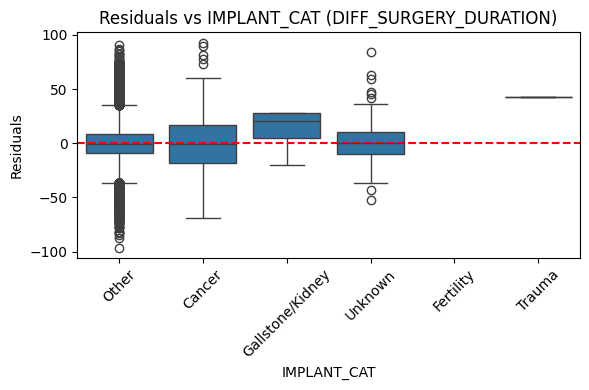

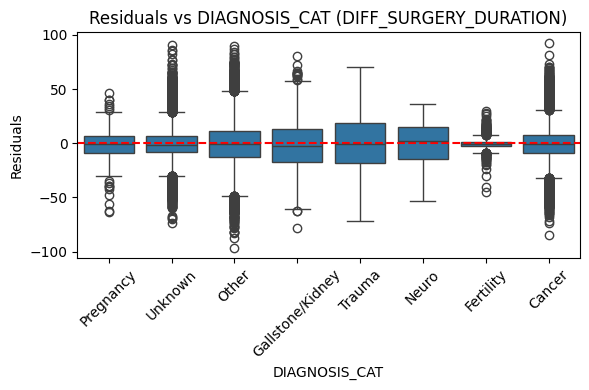

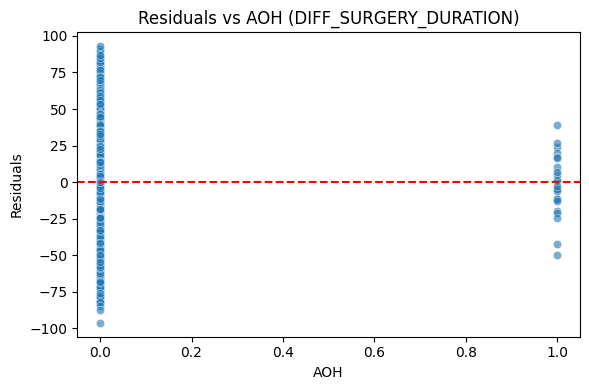

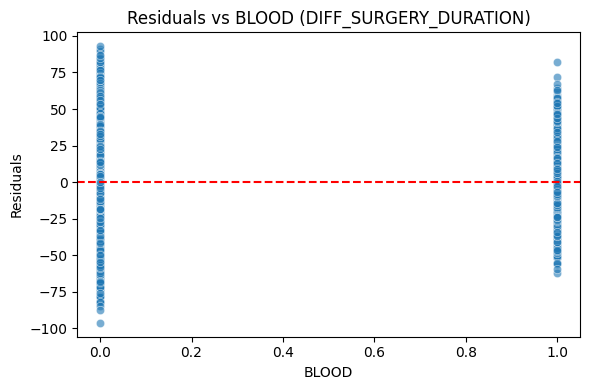

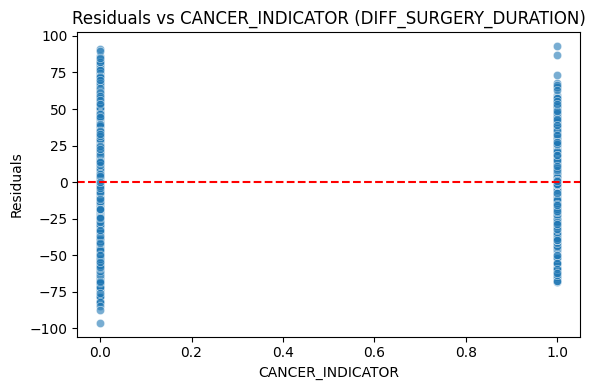

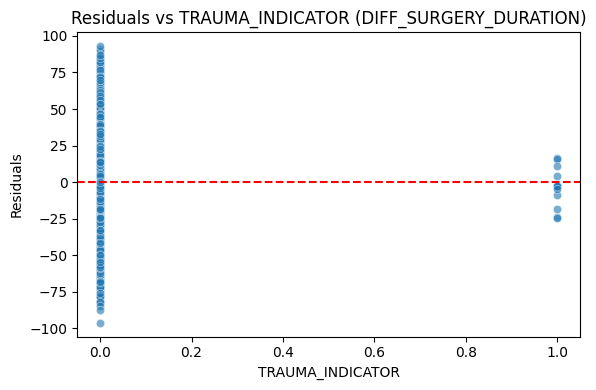

In [6]:
# Dictionary of outcomes and predictions
outcomes = {
    "DIFF_SURGERY_DURATION": (y_test['DIFF_SURGERY_DURATION'], y_pred[:, 0])
}

# Loop over all outcomes and predictors
for target_name, (y_true, y_hat) in outcomes.items():
    residuals = y_true - y_hat
    for feature_name in X_raw.columns:
        plot_residuals_vs_feature(X_raw, residuals, feature_name, target_name)

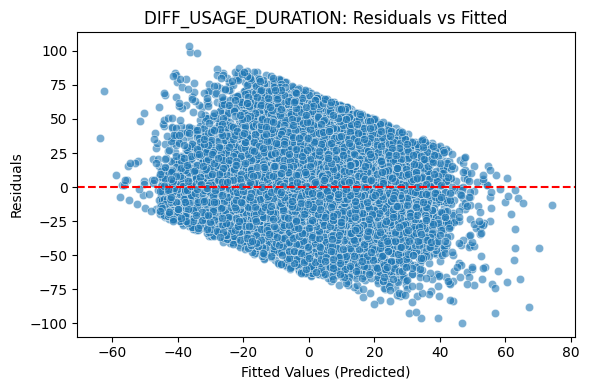

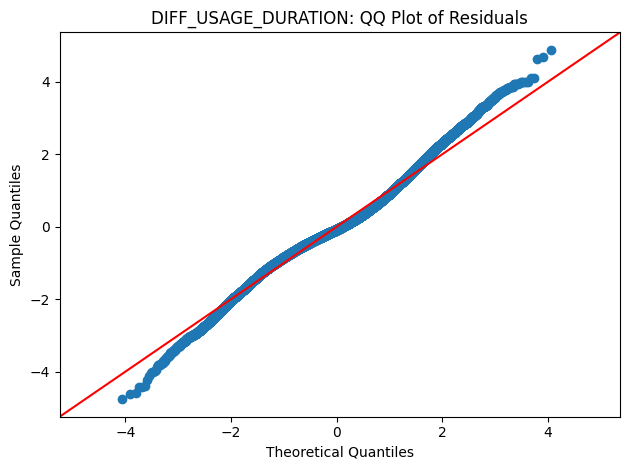

In [7]:
plot_residual_diagnostics(y_test['DIFF_USAGE_DURATION'], y_pred[:, 1], "DIFF_USAGE_DURATION")

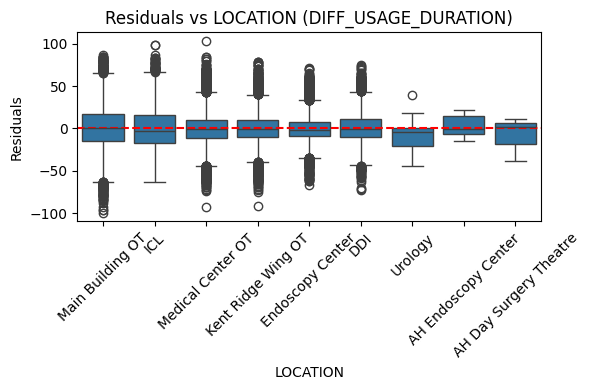

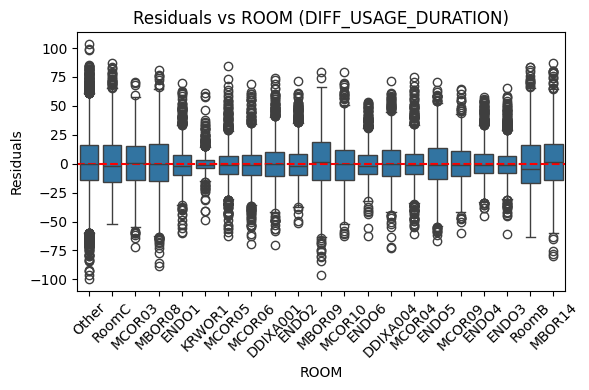

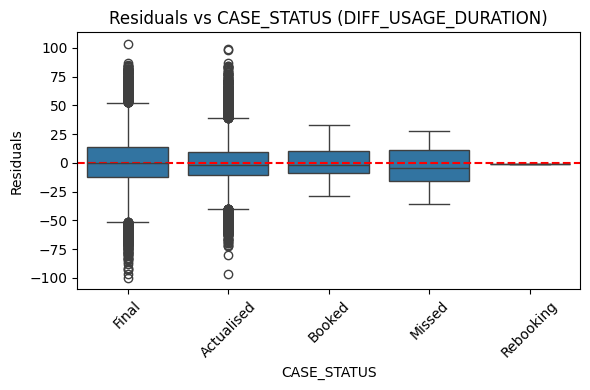

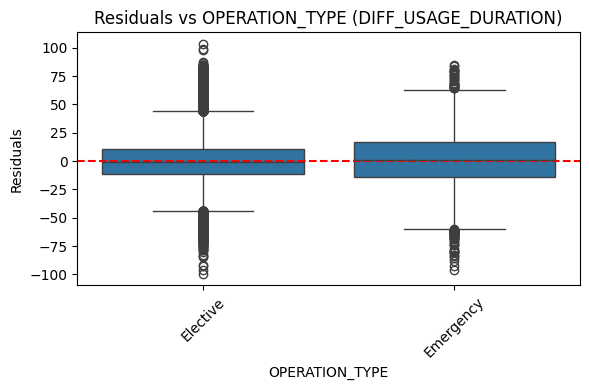

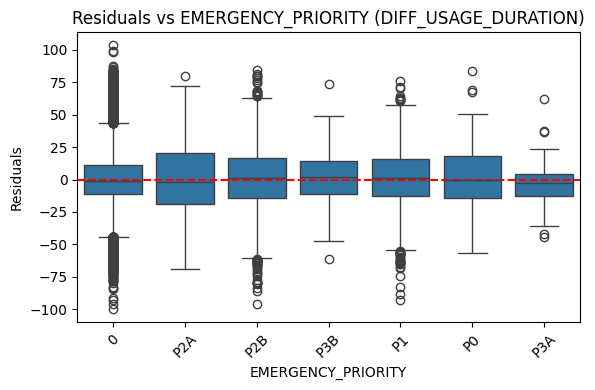

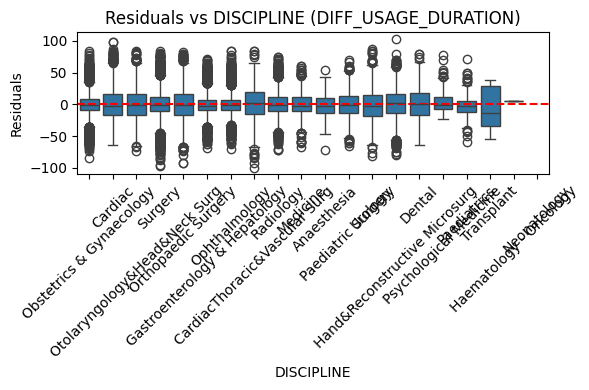

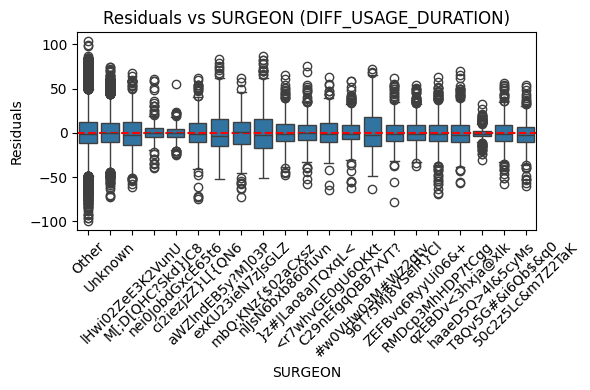

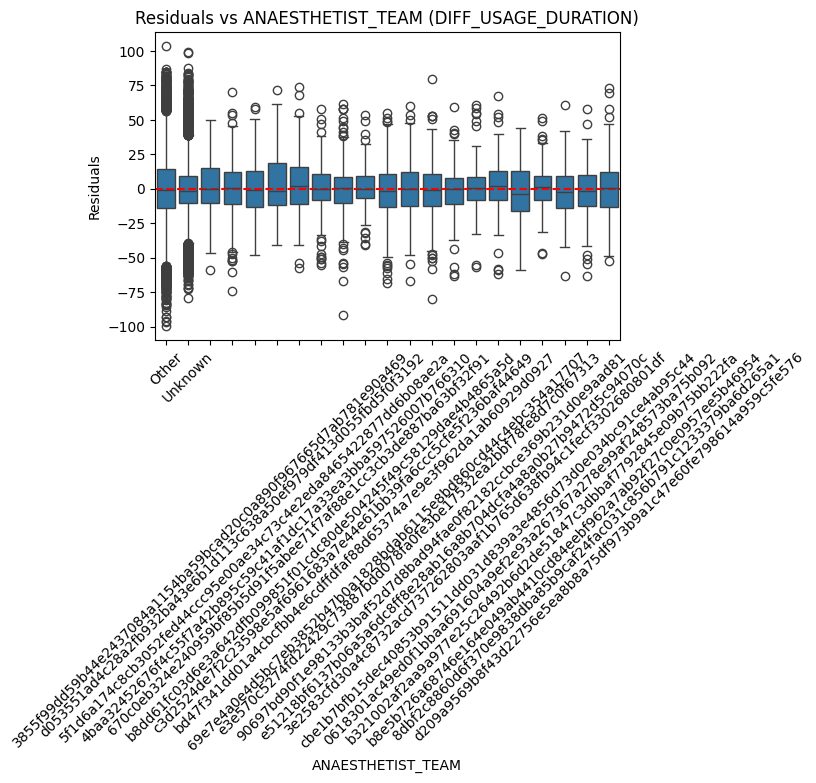

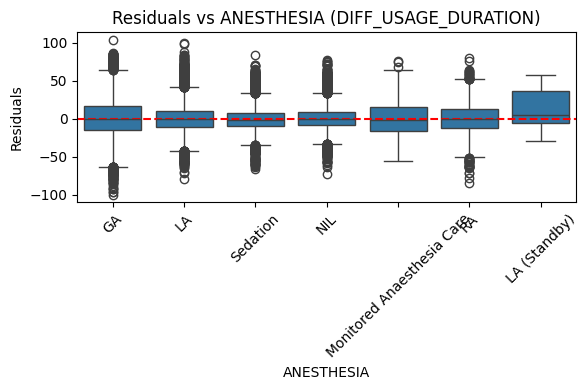

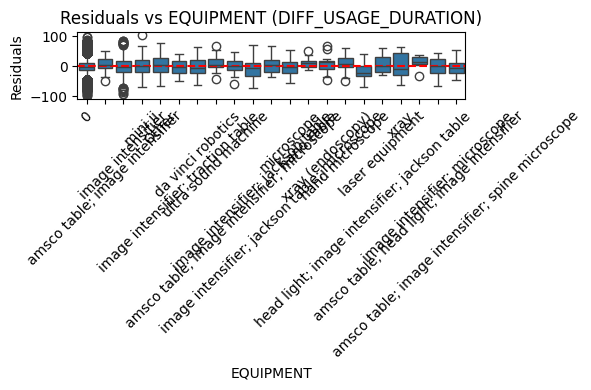

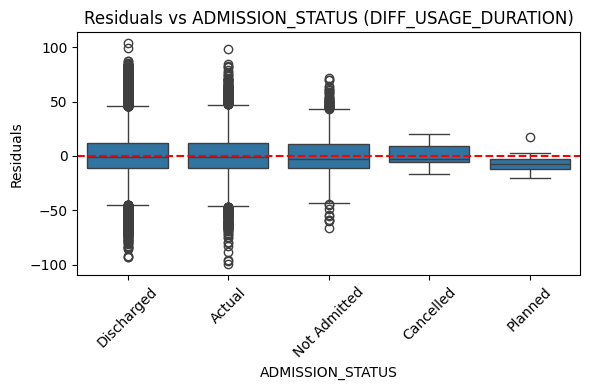

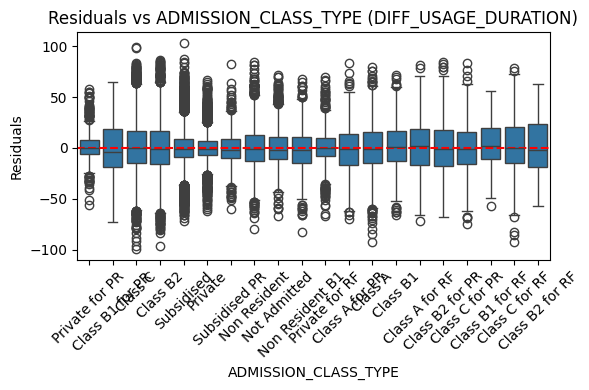

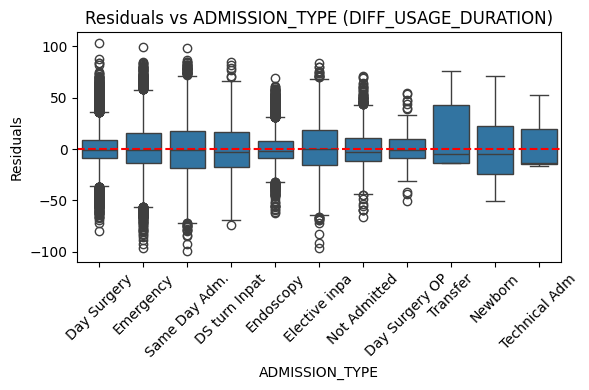

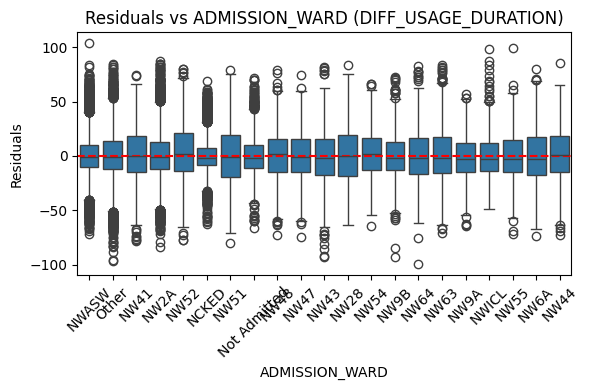

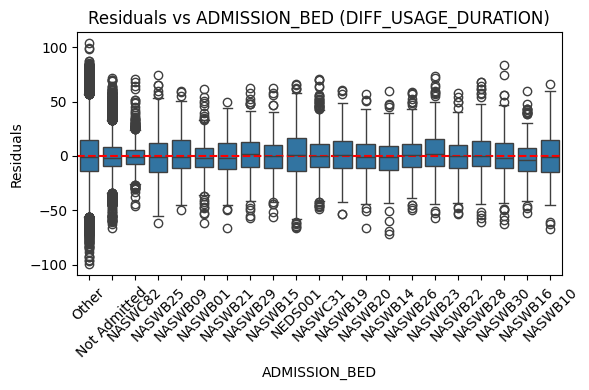

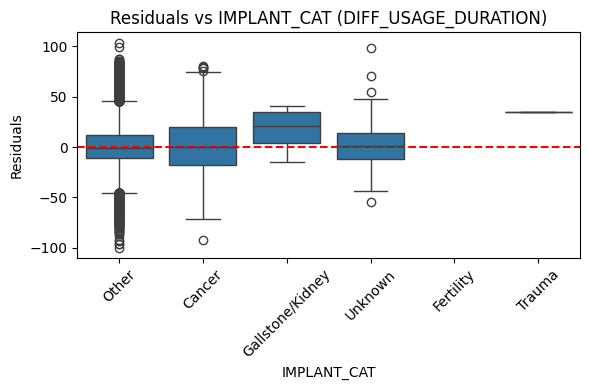

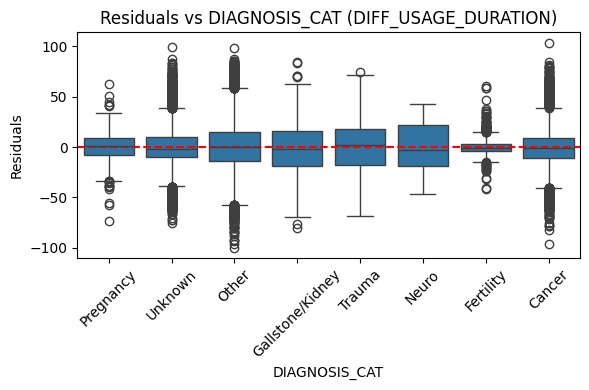

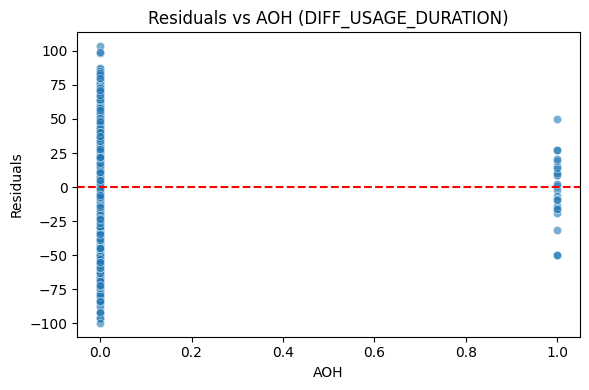

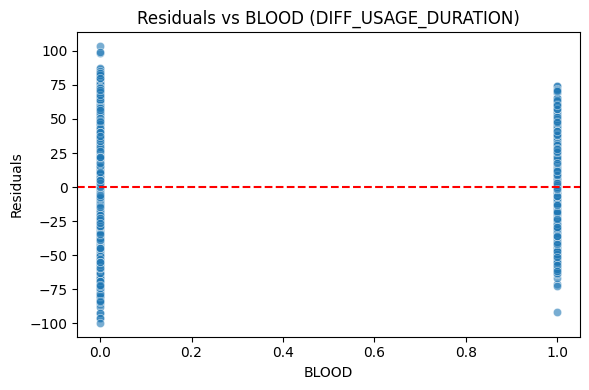

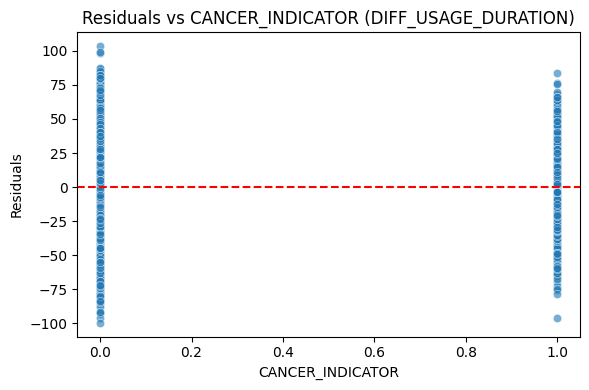

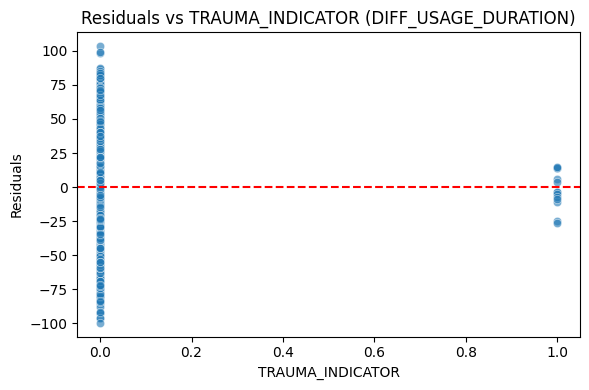

In [8]:
# Dictionary of outcomes and predictions
outcomes = {
    "DIFF_USAGE_DURATION": (y_test['DIFF_USAGE_DURATION'], y_pred[:, 1])    
}

# Loop over all outcomes and predictors
for target_name, (y_true, y_hat) in outcomes.items():
    residuals = y_true - y_hat
    for feature_name in X_raw.columns:
        plot_residuals_vs_feature(X_raw, residuals, feature_name, target_name)